# Mount Google Cloud Disk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Dependency Package

In [ ]:
!pip install scanpy gseapy umap-learn[plot] xgboost shap lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Dependency Package

In [ ]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.stats import wasserstein_distance
import gc
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats
import gseapy as gp
import networkx as nx
from tqdm import tqdm
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor
from sklearn import metrics
import shap
shap.initjs()
from sklearn.decomposition import PCA, NMF
from sklearn.metrics import auc, mean_squared_error, mean_poisson_deviance, precision_recall_curve, accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, average_precision_score
from scipy.stats import pearsonr, spearmanr, kendalltau
import pickle
import tensorflow as tf
import umap
import umap.plot
import lime
import lime.lime_tabular
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix


In [ ]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.rc('font',family='DejaVu Sans') 

In [ ]:
WORK_DIR = "/content/drive/MyDrive/SingleCellVirus/"

In [ ]:
NasalSwab = sc.read_h5ad("/content/drive/MyDrive/SingleCellVirus/Datasets/20210217_NasalSwab_Broad_BCH_UMMC_to_CZI.h5ad")
celltypes = NasalSwab.obs.Annotation.unique().to_list()
query_cells_total = NasalSwab[NasalSwab.obs.Cohort_Disease_WHO_Score=="COVID19_WHO_6-8"]
feature_names = NasalSwab.var.index[NasalSwab.var["mvp.variable"]]
query_cells_total = query_cells_total[:, feature_names]
# Reference Dataset for scVDN
ref_cells_total = NasalSwab[NasalSwab.obs.Cohort_Disease_WHO_Score=="COVID19_WHO_1-5"]
ref_cells = ref_cells_total[ref_cells_total.obs.Annotation=="Ciliated Cells"]
ref_cells = ref_cells[:, feature_names]
ref_pos_data = ref_cells[ref_cells.obs.query("SingleCell_SARSCoV2_RNA_Status=='pos'").index].X.A
del NasalSwab, ref_cells_total
gc.collect()

98673

In [ ]:
def saveobj(obj, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)

def loadobj(filepath):
    pkl_file = open(filepath, 'rb')
    return pickle.load(pkl_file)

def roc_plot(fpr, tpr, model_name, xylim_size=9, **kwargs):
    plt.plot(fpr, tpr, label='{} (AUC={:.3f})'.format(model_name, auc(fpr, tpr)), **kwargs)
    plt.axis('square')
    plt.xticks(size=xylim_size)
    plt.yticks(size=xylim_size)
    plt.xlim([0, 1])
    plt.ylim([0, 1])

In [ ]:
def auto_roc_4_scVDN(modelpath, query_cells):
    # Load data required for drawing
    pos_obs = query_cells.obs.query("SingleCell_SARSCoV2_RNA_Status=='pos'")
    neg_obs = query_cells.obs.query("SingleCell_SARSCoV2_RNA_Status=='neg'")

    pos_anndata = query_cells[pos_obs.index][:, feature_names]
    neg_anndata = query_cells[neg_obs.index][:, feature_names]

    query_pos_data = pos_anndata.X.A
    query_neg_data = neg_anndata.X.A

    test_data = []
    test_label = []
    temp_count1 = ref_pos_data.shape[0]
    temp_count2 = query_pos_data.shape[0]

    for i in range(temp_count2):
        for j in range(temp_count1):
            test_data.append([ref_pos_data[j], query_pos_data[i]])
            test_label.append([1])

    temp_count1 = ref_pos_data.shape[0]
    temp_count2 = query_neg_data.shape[0]
    for i in range(temp_count2):
        for j in range(temp_count1):
            test_data.append([ref_pos_data[j], query_neg_data[i]])
            test_label.append([0])

    test_data = np.array(test_data)
    test_data_right = test_data[:,0,:]
    test_data_left = test_data[:,1,:]

    del pos_anndata, neg_anndata, pos_obs, neg_obs
    gc.collect()

    y = test_label
    model = loadobj(modelpath)
    pred_y = model.predict([test_data_right, test_data_left], verbose=0)
    fpr, tpr, thresholds = metrics.roc_curve(y, pred_y, pos_label=1)

    return fpr, tpr, thresholds

def auto_roc_4_scVDN_by_celltype(modelpath, celltype):
    query_cells = query_cells_total[query_cells_total.obs.Annotation==celltype]
    return auto_roc_4_scVDN(modelpath, query_cells)

def auto_roc_4_mlmodel(modelpath, query_cells):
    pos_obs = query_cells.obs.query("SingleCell_SARSCoV2_RNA_Status=='pos'")
    neg_obs = query_cells.obs.query("SingleCell_SARSCoV2_RNA_Status=='neg'")

    pos_anndata = query_cells[pos_obs.index][:, feature_names]
    neg_anndata = query_cells[neg_obs.index][:, feature_names]

    query_pos_data = pos_anndata.X.A
    query_neg_data = neg_anndata.X.A

    del pos_anndata, neg_anndata, pos_obs, neg_obs
    gc.collect()

    test_data = np.vstack((query_pos_data, query_neg_data))
    test_label = np.hstack((np.ones(query_pos_data.shape[0]), np.zeros(query_neg_data.shape[0])))
    
    y = test_label
    model = loadobj(modelpath)
    pred_y = model.predict(test_data)
    fpr, tpr, thresholds = metrics.roc_curve(y, pred_y, pos_label=1)

    return fpr, tpr, thresholds

def auto_roc_4_mlmodel_by_celltype(modelpath, celltype):
    query_cells = query_cells_total[query_cells_total.obs.Annotation==celltype]
    return auto_roc_4_mlmodel(modelpath, query_cells)

# ROC curves of all models on the specified dataset (cell subtypes)

In [ ]:
def draw_roc_by_celltype(celltype):
    plt.figure(figsize=(2.5, 2.5))
    plt.title(celltype, fontsize=10)
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)

    plt.plot([0, 1], [0, 1], linewidth=1, linestyle=":", color="gray")

    modelpath = os.path.join(WORK_DIR, "siamese_final.pkl")
    fpr, tpr, thresholds = auto_roc_4_scVDN_by_celltype(modelpath, celltype)
    roc_plot(fpr, tpr, "scVDN", linewidth=1, linestyle="--", color="green")

    modelpath = os.path.join(WORK_DIR, "KNN_model.pkl")
    fpr, tpr, thresholds = auto_roc_4_mlmodel_by_celltype(modelpath, celltype)
    roc_plot(fpr, tpr, "KNN", linewidth=1, linestyle="--", color="#DEBD59")

    modelpath = os.path.join(WORK_DIR, "SVM_model.pkl")
    fpr, tpr, thresholds = auto_roc_4_mlmodel_by_celltype(modelpath, celltype)
    roc_plot(fpr, tpr, "SVM", linewidth=1, linestyle="--", color="#D069B5")

    modelpath = os.path.join(WORK_DIR, "NB_model.pkl")
    fpr, tpr, thresholds = auto_roc_4_mlmodel_by_celltype(modelpath, celltype)
    roc_plot(fpr, tpr, "NB", linewidth=1, linestyle="--", color="#8FAADC")

    modelpath = os.path.join(WORK_DIR, "RF_model.pkl")
    fpr, tpr, thresholds = auto_roc_4_mlmodel_by_celltype(modelpath, celltype)
    roc_plot(fpr, tpr, "RF", linewidth=1, linestyle="--", color="#FFBF00")

    plt.legend(loc='lower right',fontsize=6)
    plt.show()
    plt.close()


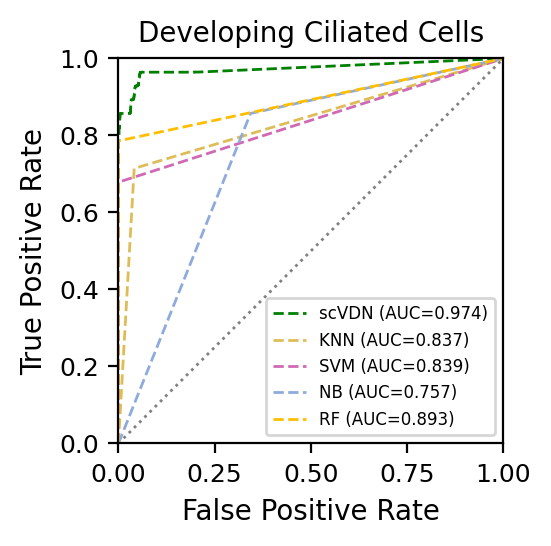

In [ ]:
draw_roc_by_celltype("Developing Ciliated Cells")

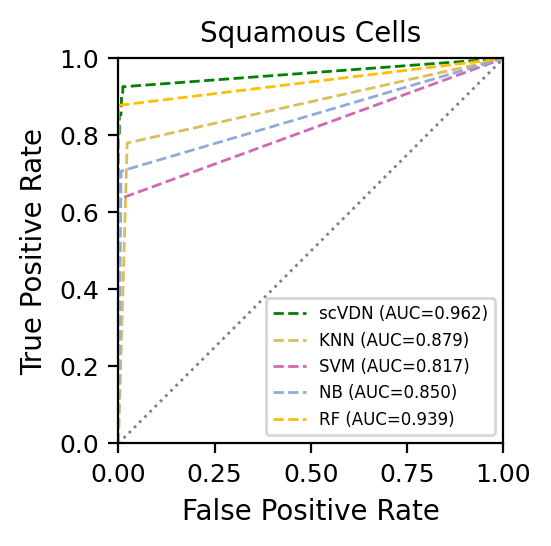

In [ ]:
draw_roc_by_celltype("Squamous Cells")

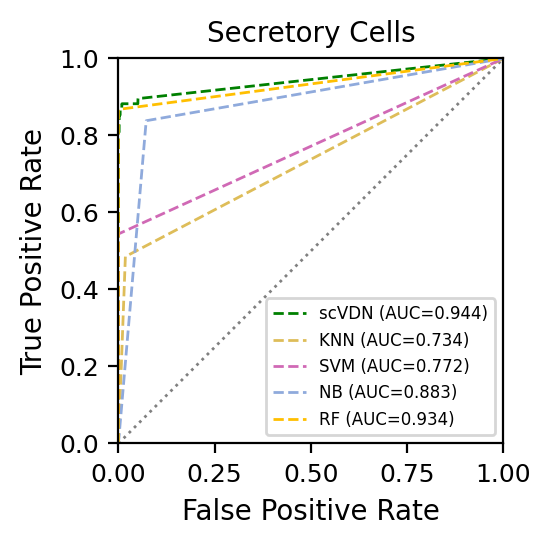

In [ ]:
draw_roc_by_celltype("Secretory Cells")

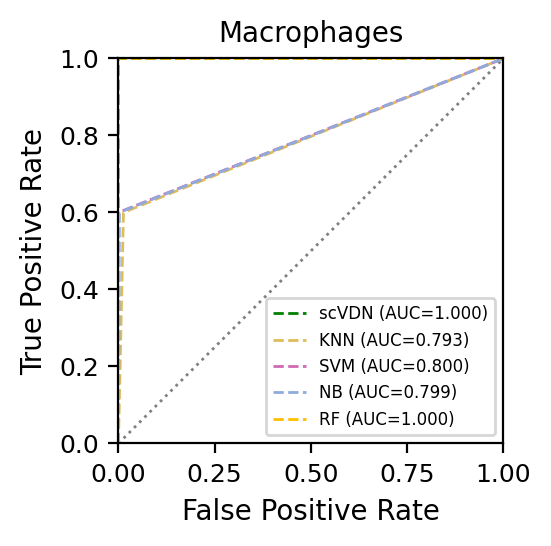

In [ ]:
draw_roc_by_celltype("Macrophages")

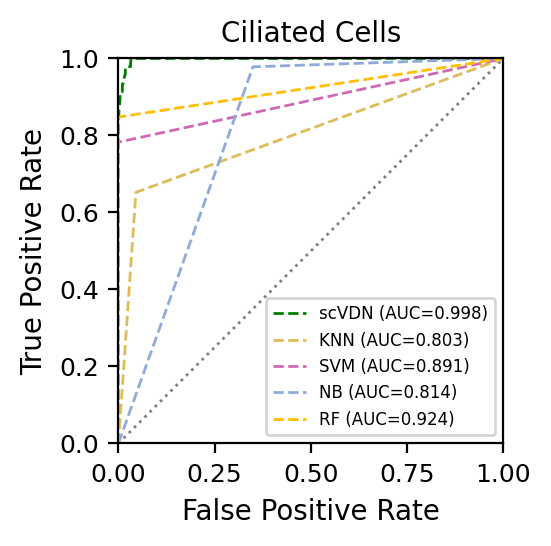

In [ ]:
draw_roc_by_celltype("Ciliated Cells")

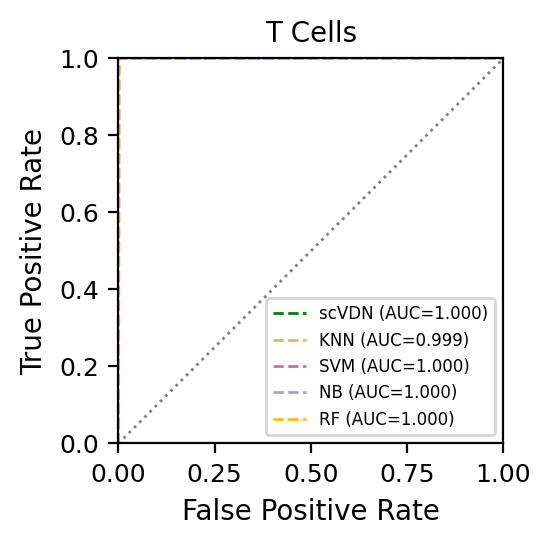

In [ ]:
draw_roc_by_celltype("T Cells")

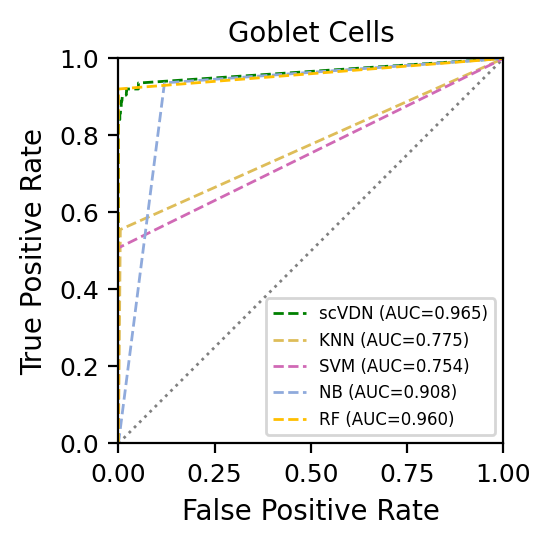

In [ ]:
draw_roc_by_celltype("Goblet Cells")

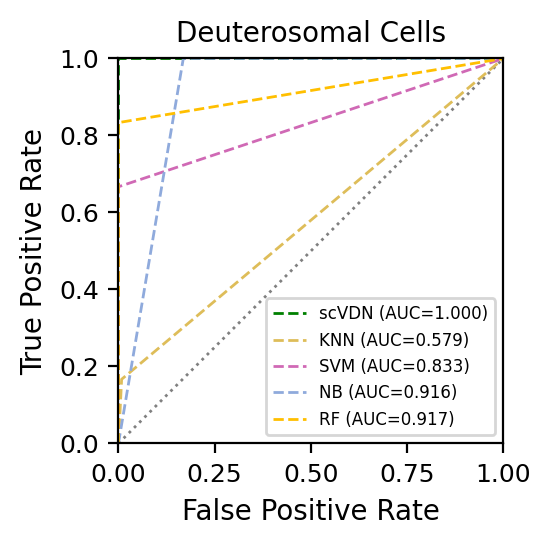

In [ ]:
draw_roc_by_celltype("Deuterosomal Cells")

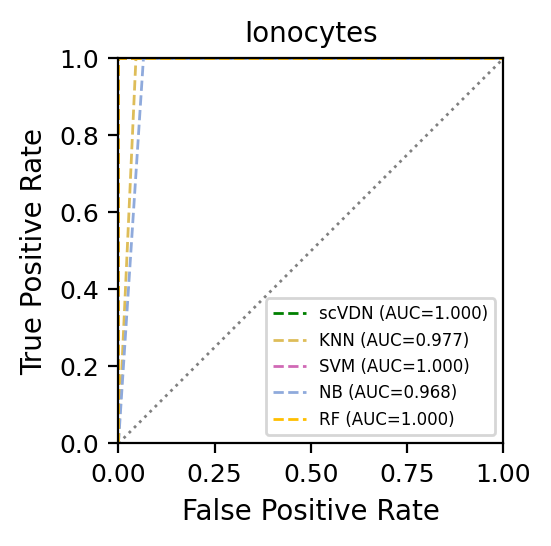

In [ ]:
draw_roc_by_celltype("Ionocytes")

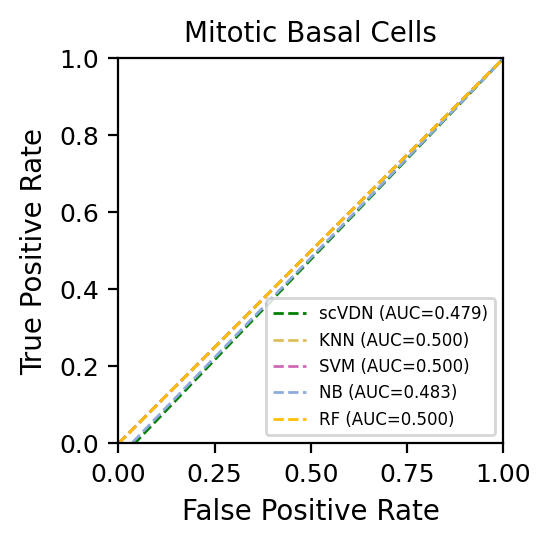

In [ ]:
draw_roc_by_celltype("Mitotic Basal Cells")

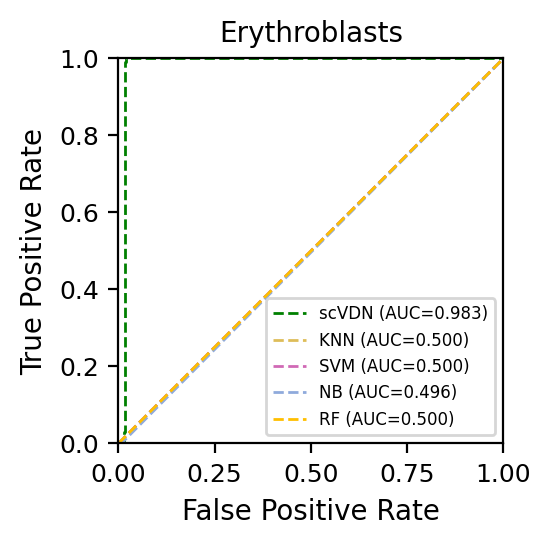

In [ ]:
draw_roc_by_celltype("Erythroblasts")

# ROC curves of all models on all cell data (without distinguishing cell subtypes)

100%|██████████| 18/18 [06:32<00:00, 21.79s/it]


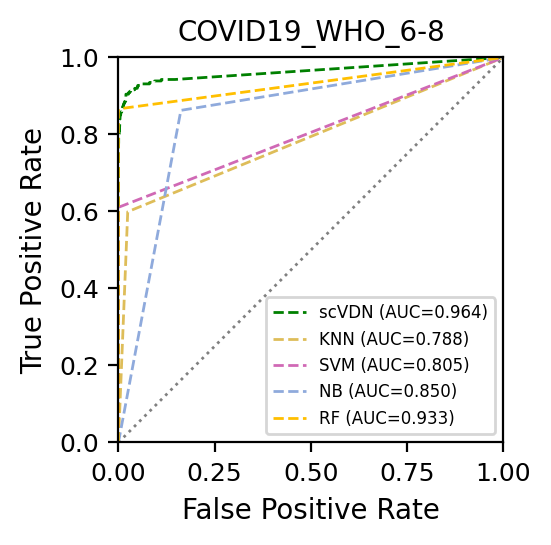

In [ ]:
plt.figure(figsize=(2.5, 2.5))
plt.title("COVID19_WHO_6-8", fontsize=10)
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)

plt.plot([0, 1], [0, 1], linewidth=1, linestyle=":", color="gray")

y = np.zeros(0)
pred_y = np.zeros(0)
siamese_model = loadobj(os.path.join(WORK_DIR, "siamese_final.pkl"))
for query_celltype in tqdm(celltypes):
    query_cells = query_cells_total[query_cells_total.obs.Annotation==query_celltype]

    pos_obs = query_cells.obs.query("SingleCell_SARSCoV2_RNA_Status=='pos'")
    neg_obs = query_cells.obs.query("SingleCell_SARSCoV2_RNA_Status=='neg'")

    pos_anndata = query_cells[pos_obs.index][:, feature_names]
    neg_anndata = query_cells[neg_obs.index][:, feature_names]

    query_pos_data = pos_anndata.X.A
    query_neg_data = neg_anndata.X.A

    del pos_anndata, neg_anndata, pos_obs, neg_obs
    gc.collect()

    test_data = []
    test_label = []
    temp_count1 = ref_pos_data.shape[0]
    temp_count2 = query_pos_data.shape[0]

    for i in range(temp_count2):
        for j in range(temp_count1):
            test_data.append([ref_pos_data[j], query_pos_data[i]])
            test_label.append([1])

    temp_count1 = ref_pos_data.shape[0]
    temp_count2 = query_neg_data.shape[0]
    for i in range(temp_count2):
        for j in range(temp_count1):
            test_data.append([ref_pos_data[j], query_neg_data[i]])
            test_label.append([0])

    test_data = np.array(test_data)
    test_data_right = test_data[:,0,:]
    test_data_left = test_data[:,1,:]
    
    del test_data
    gc.collect()

    y_part = np.array(test_label).reshape(-1)

    pred_y_part = siamese_model.predict([test_data_right, test_data_left], verbose=0)
    pred_y_part = pred_y_part.ravel()

    y = np.hstack((y, y_part))
    pred_y = np.hstack((pred_y, pred_y_part))

data_count = y.shape[0]
ref_data_count = 100
ensemble_data_count = int(data_count/ref_data_count)

ensemble_y = np.zeros(int(data_count/ref_data_count))
ensemble_pred_y = np.zeros(int(data_count/ref_data_count))

for i in range(ensemble_data_count):
    ensemble_y[i] = np.mean(y[i*ref_data_count: (i+1)*ref_data_count])
    ensemble_pred_y[i] = np.mean(pred_y[i*ref_data_count: (i+1)*ref_data_count])

y = ensemble_y
pred_y = ensemble_pred_y

fpr, tpr, thresholds = metrics.roc_curve(y, pred_y, pos_label=1)
roc_plot(fpr, tpr, "scVDN", linewidth=1, linestyle="--", color="green")

modelpath = os.path.join(WORK_DIR, "KNN_model.pkl")
fpr, tpr, thresholds = auto_roc_4_mlmodel(modelpath, query_cells_total)
roc_plot(fpr, tpr, "KNN", linewidth=1, linestyle="--", color="#DEBD59")

modelpath = os.path.join(WORK_DIR, "SVM_model.pkl")
fpr, tpr, thresholds = auto_roc_4_mlmodel(modelpath, query_cells_total)
roc_plot(fpr, tpr, "SVM", linewidth=1, linestyle="--", color="#D069B5")

modelpath = os.path.join(WORK_DIR, "NB_model.pkl")
fpr, tpr, thresholds = auto_roc_4_mlmodel(modelpath, query_cells_total)
roc_plot(fpr, tpr, "NB", linewidth=1, linestyle="--", color="#8FAADC")

modelpath = os.path.join(WORK_DIR, "RF_model.pkl")
fpr, tpr, thresholds = auto_roc_4_mlmodel(modelpath, query_cells_total)
roc_plot(fpr, tpr, "RF", linewidth=1, linestyle="--", color="#FFBF00")


plt.legend(loc='lower right',fontsize=6)
plt.show()
plt.close()

# Single cell data visualization

In [ ]:
NasalSwab = sc.read_h5ad("/content/drive/MyDrive/SingleCellVirus/Datasets/20210217_NasalSwab_Broad_BCH_UMMC_to_CZI.h5ad")

In [ ]:
ref_cells_total = NasalSwab[NasalSwab.obs.Cohort_Disease_WHO_Score=="COVID19_WHO_1-5"]
query_cells_total = NasalSwab[NasalSwab.obs.Cohort_Disease_WHO_Score=="COVID19_WHO_6-8"]

In [ ]:
print("ref_cells_count", ref_cells_total.shape[0])
print("query_cells_count", query_cells_total.shape[0])

ref_cells_count 5164
query_cells_count 12909


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


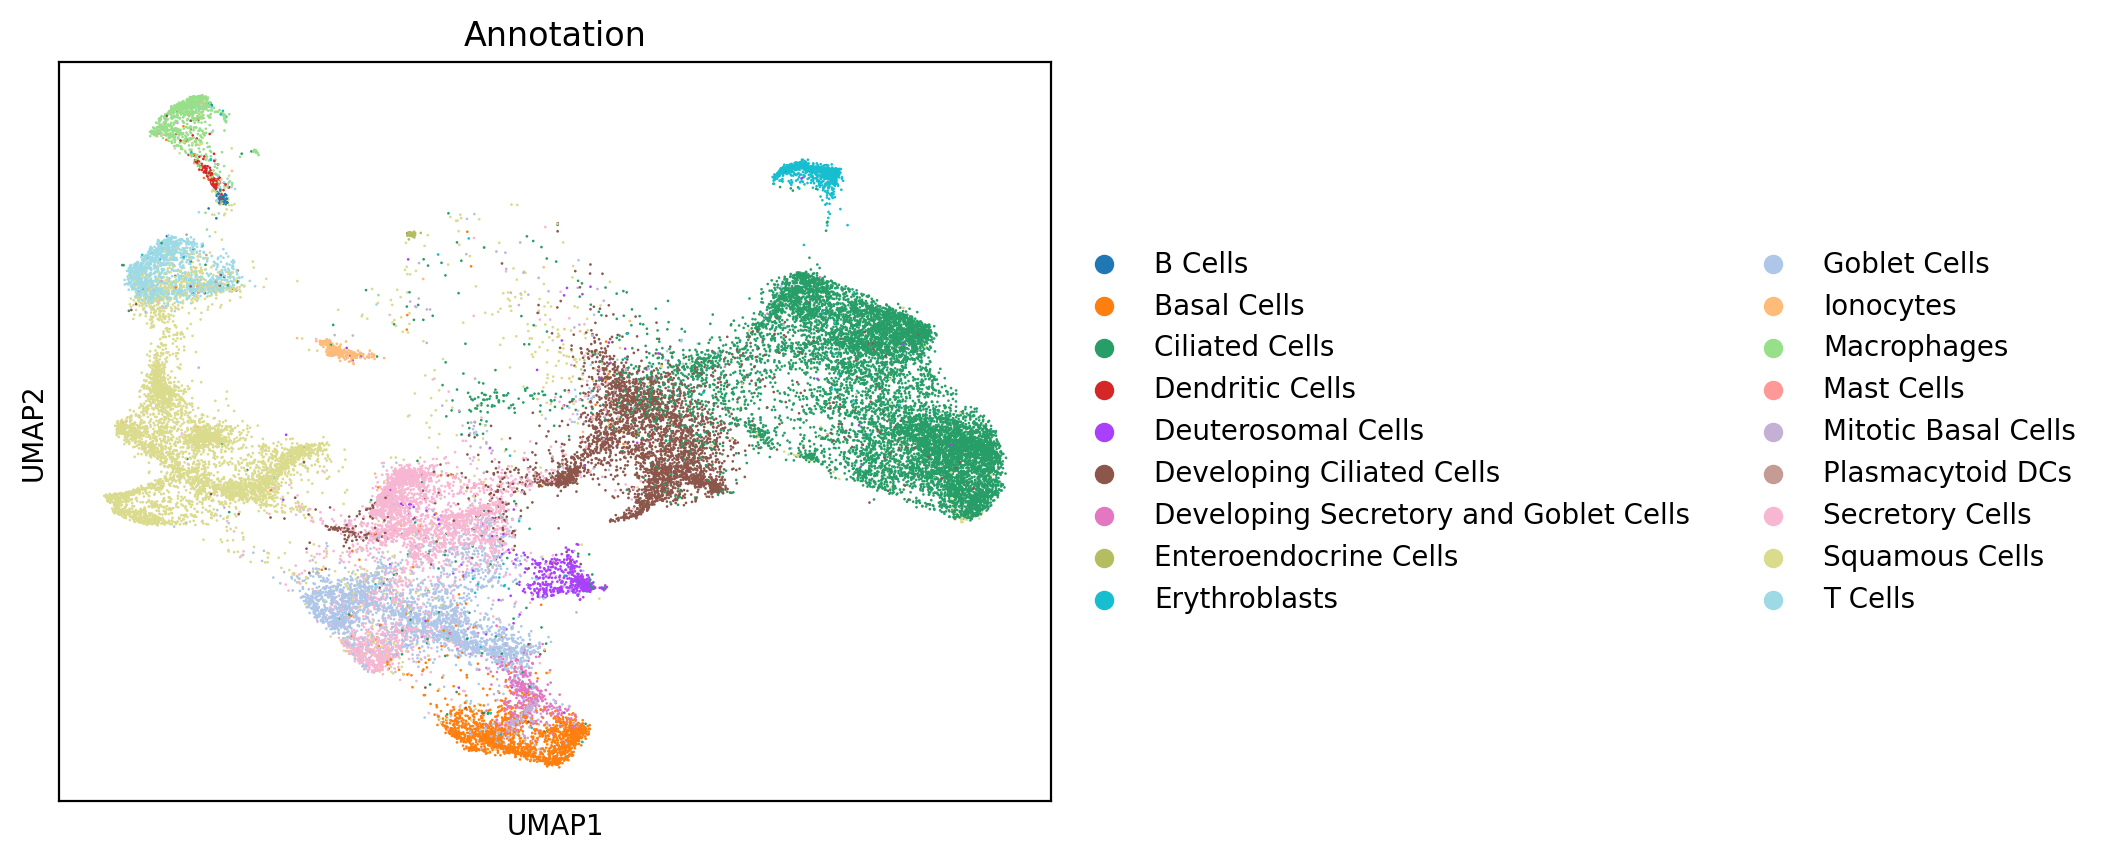

In [ ]:
sc.pl.umap(NasalSwab, color="Annotation")

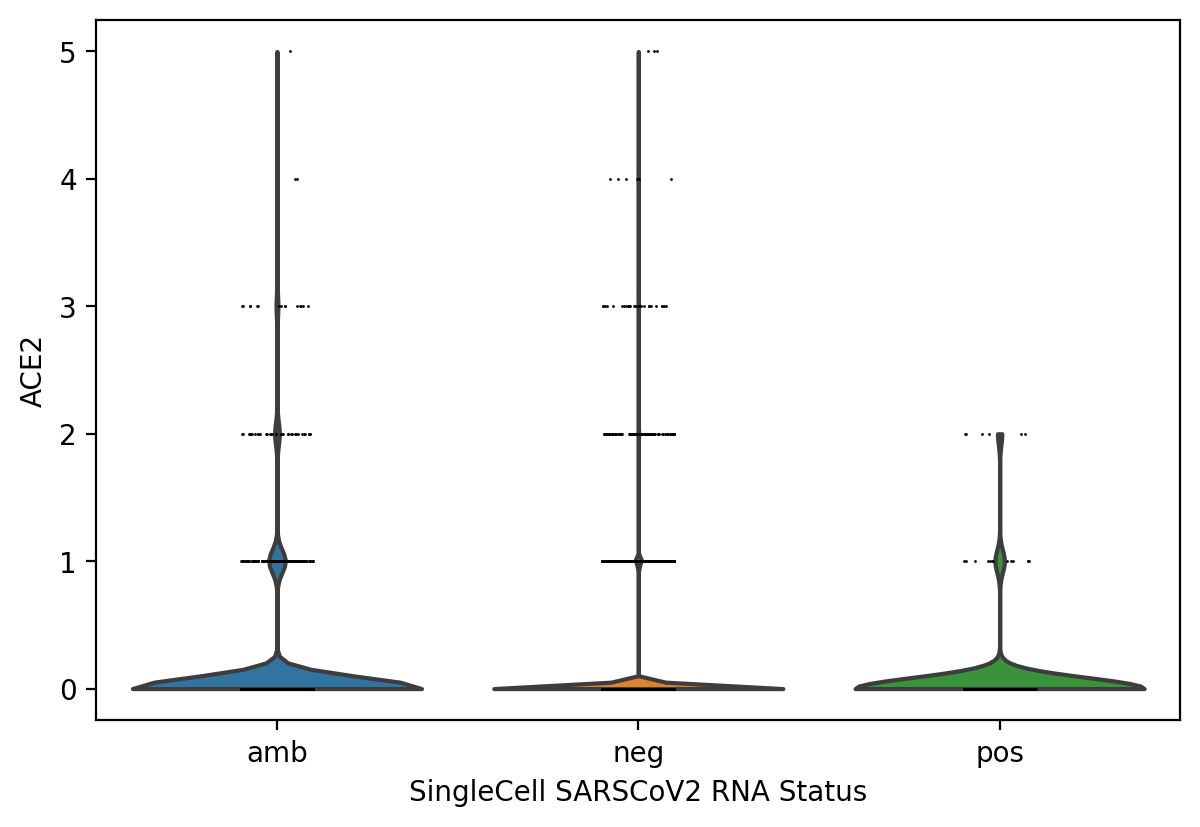

In [ ]:
sc.pl.violin(NasalSwab, keys="ACE2", groupby="SingleCell_SARSCoV2_RNA_Status")

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


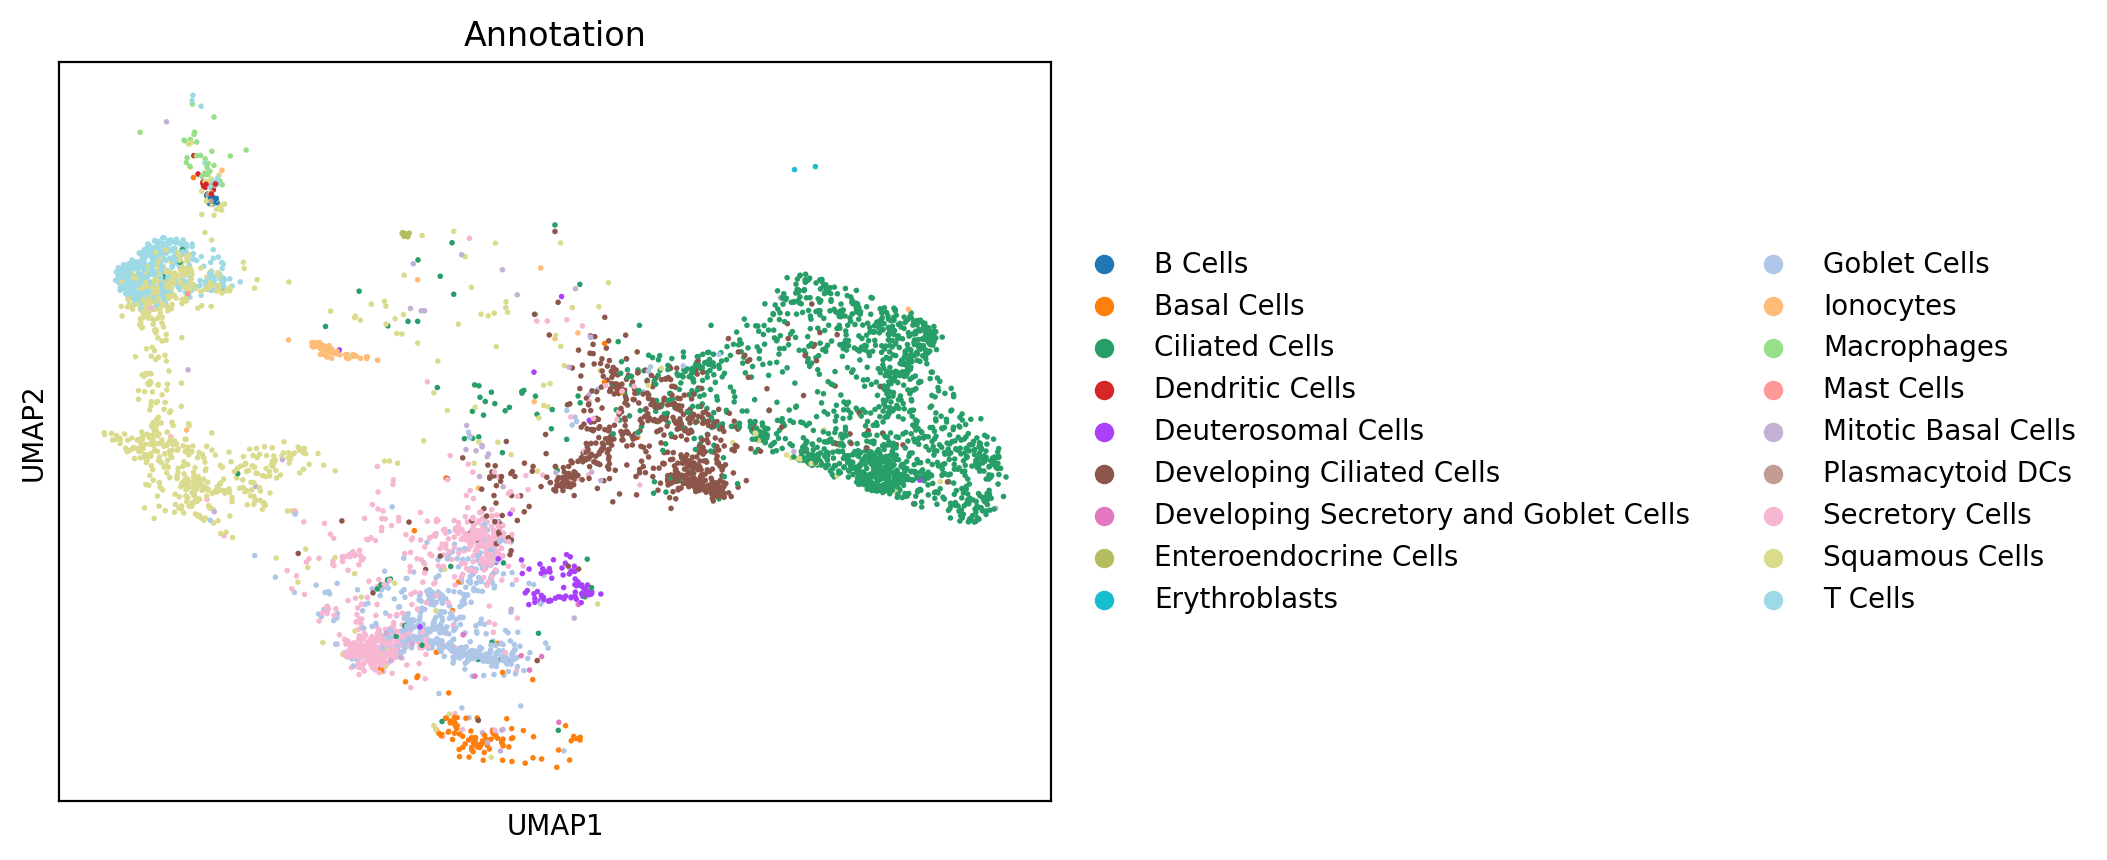

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


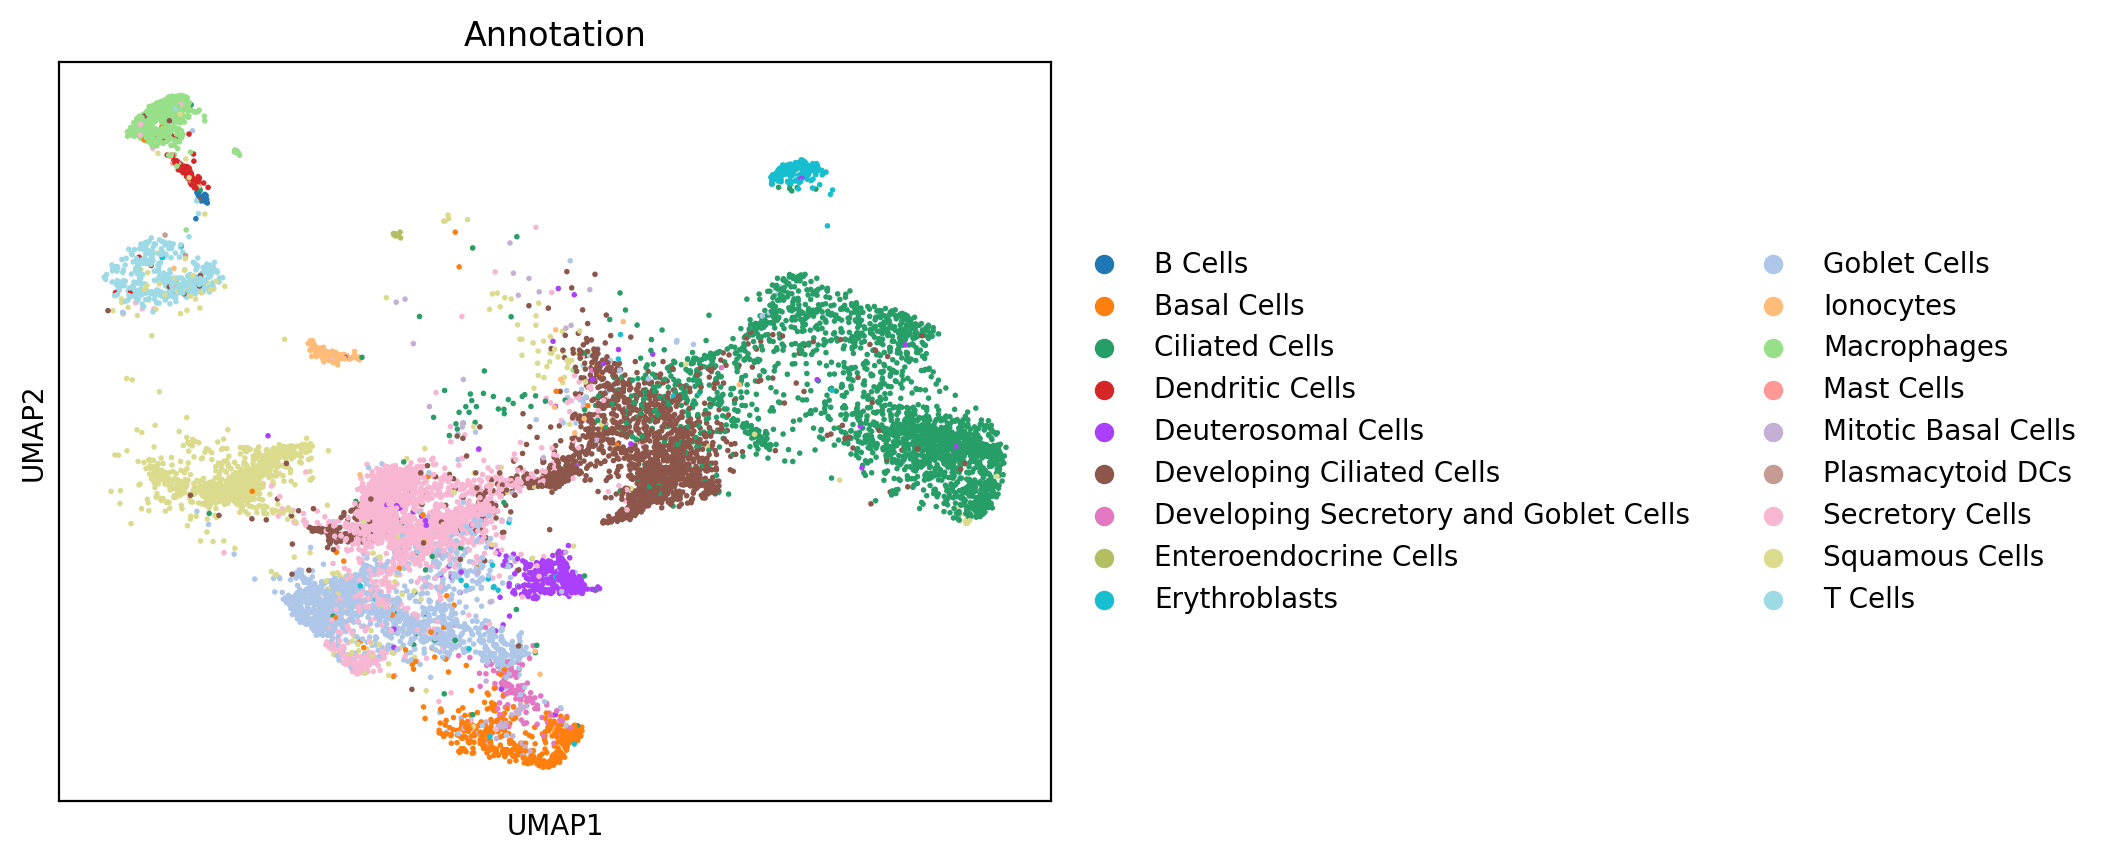

In [ ]:
sc.pl.umap(ref_cells_total, color="Annotation", size=16)
sc.pl.umap(query_cells_total, color="Annotation", size=16)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


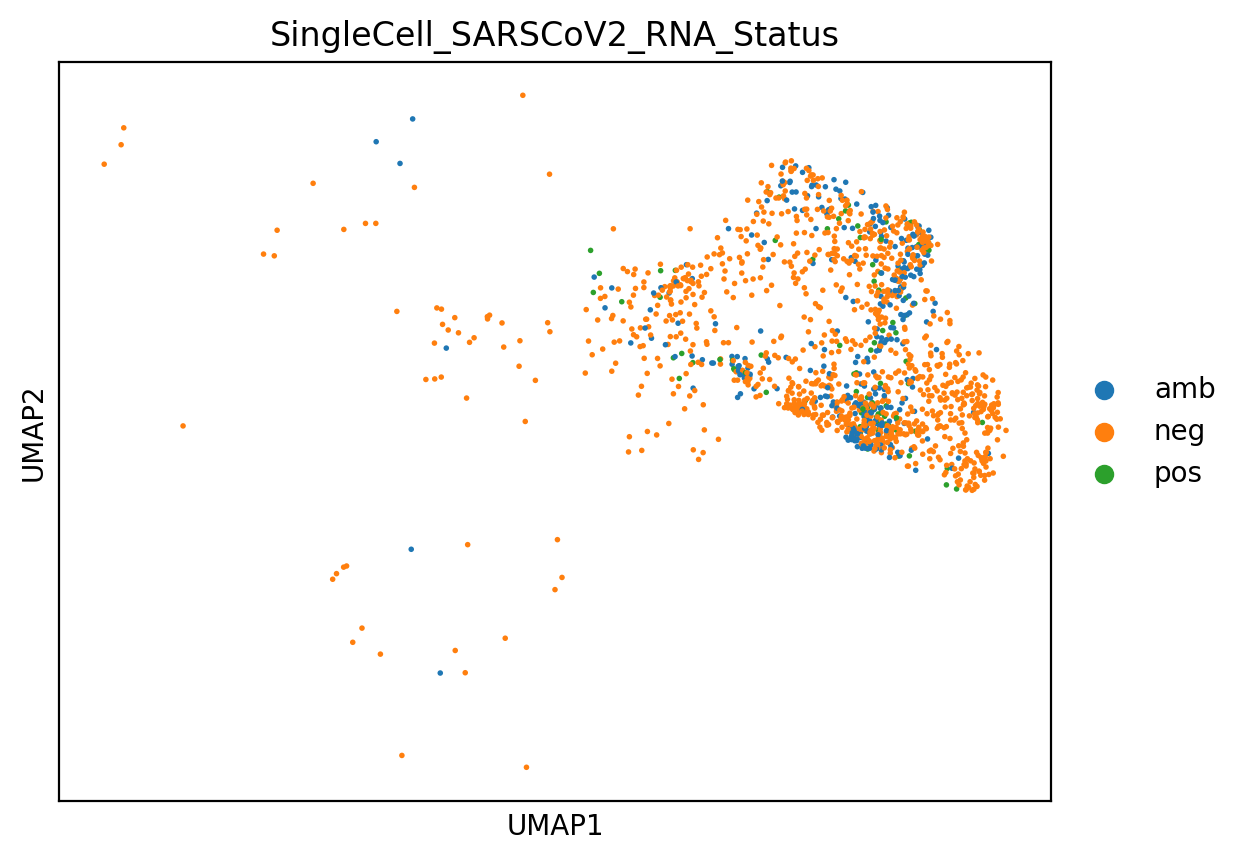

In [ ]:
# Ciliated Cells
ref_cells_total = NasalSwab[NasalSwab.obs.Cohort_Disease_WHO_Score=="COVID19_WHO_1-5"]
ref_Ciliated_Cells = ref_cells_total[ref_cells_total.obs.Annotation=="Ciliated Cells"]
sc.pl.umap(ref_Ciliated_Cells, color="SingleCell_SARSCoV2_RNA_Status", size=16)

In [ ]:
print("amb:", ref_Ciliated_Cells[ref_Ciliated_Cells.obs.SingleCell_SARSCoV2_RNA_Status=="amb"].shape[0])
print("neg:", ref_Ciliated_Cells[ref_Ciliated_Cells.obs.SingleCell_SARSCoV2_RNA_Status=="neg"].shape[0])
print("pos:", ref_Ciliated_Cells[ref_Ciliated_Cells.obs.SingleCell_SARSCoV2_RNA_Status=="pos"].shape[0])

amb: 342
neg: 1172
pos: 100


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


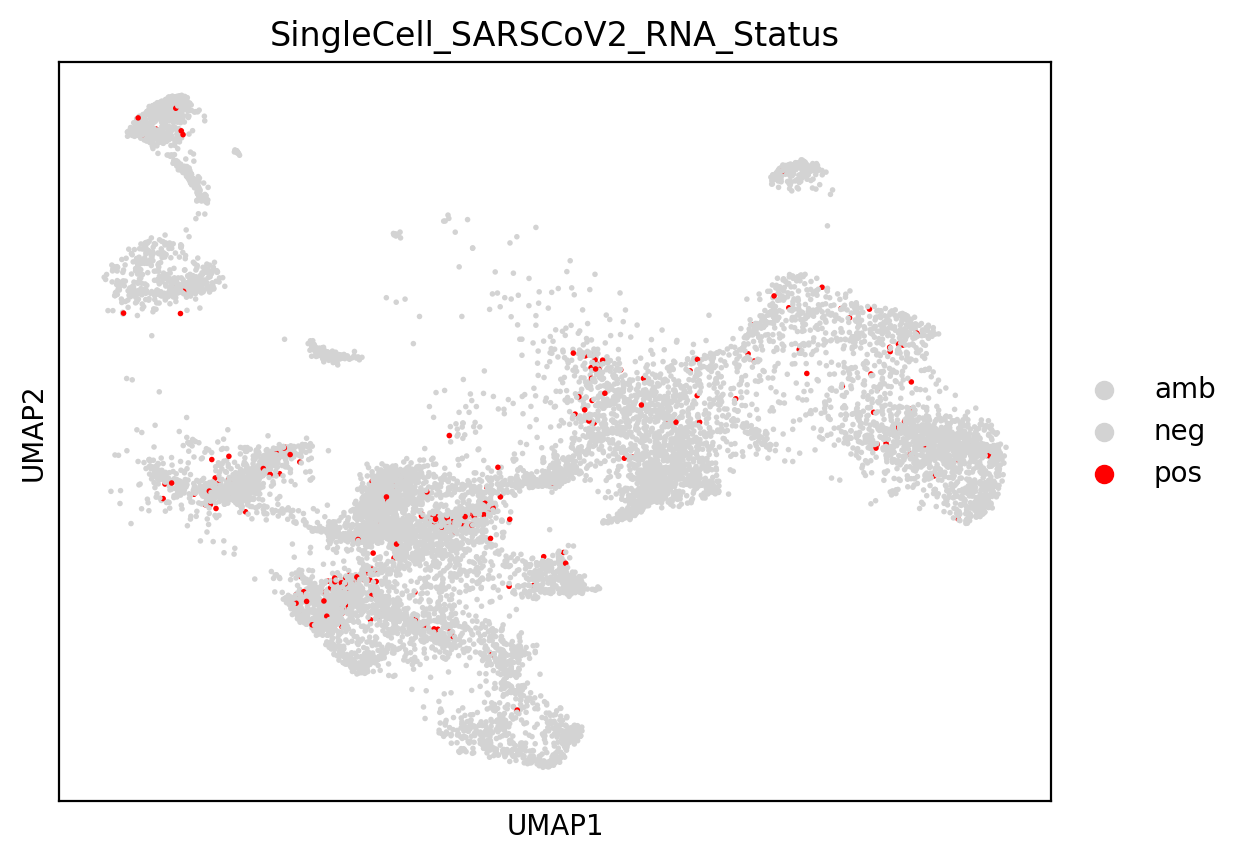

In [ ]:
sc.pl.umap(query_cells_total, color="SingleCell_SARSCoV2_RNA_Status", size=16, palette={
    "amb":"lightgray",
    "neg":"lightgray",
    "pos":"red"
})